This notebook is very similar to `class_sz_CIB.ipynb`. Refer to that notebook for CIB autospectrum with `class_sz`.

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
from classy_sz import Class
import os
import time

Metal device set to: Apple M1 Pro


2023-03-25 11:50:02.529106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-25 11:50:02.529216: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# a simple conversion from cl's to dl's
def cl_to_dl(lp):
    return lp*(lp+1.)/2./np.pi

# CIB x $\kappa$ Power Spectrum

## Set Parameters

You can set `class_sz` parameters individually, in a single dictionary, or multiple dictionaries.

First, let's establish the cosmology. McCarthy et al. use Planck 2014 cosmology (https://arxiv.org/pdf/1303.5076.pdf, best-fit).

In [3]:
#Parameters for Cosmology Planck 14, https://arxiv.org/pdf/1303.5076.pdf, best-fit
p14_dict={}
p14_dict['h'] = 0.6711      
p14_dict['omega_b'] = 0.022068
p14_dict['Omega_cdm'] = 0.3175-0.022068/0.6711/0.6711
p14_dict['A_s'] = 2.2e-9
p14_dict['n_s'] = .9624
p14_dict['k_pivot'] = 0.05
p14_dict['tau_reio'] = 0.0925
p14_dict['N_ncdm'] = 1
p14_dict['N_ur'] = 0.00641
p14_dict['deg_ncdm'] = 3
p14_dict['m_ncdm'] = 0.02
p14_dict['T_ncdm'] = 0.71611

Since `cosmopower` requires certain cosmological parameters, we'll create a second dictionary for them.

In [4]:
#Parameters for Cosmology Planck 14, https://arxiv.org/pdf/1303.5076.pdf, best-fit
p_cp_dict={}
p_cp_dict['H0'] = 67.11      # need this because this is what is used by the emulators
p_cp_dict['omega_b'] = 0.022068
p_cp_dict['omega_cdm'] = (0.3175 * p_cp_dict['H0']**2) - p_cp_dict['omega_b']    # need this because this is what is used by the emulators
p_cp_dict['ln10^{10}A_s'] = 3.0980           # need this because this is what is used by the emulators
p_cp_dict['n_s'] = .9624
p_cp_dict['k_pivot'] = 0.05
p_cp_dict['tau_reio'] = 0.0925
p_cp_dict['N_ncdm'] = 1
p_cp_dict['N_ur'] = 0.00641
p_cp_dict['deg_ncdm'] = 3
p_cp_dict['m_ncdm'] = 0.02
p_cp_dict['T_ncdm'] = 0.71611

Halo Model and grid parameters:

In [6]:
p_hm_dict = {}

p_hm_dict['mass function'] = 'T10'
p_hm_dict['concentration parameter'] = 'D08'
p_hm_dict['delta for cib'] = '200m'
p_hm_dict['hm_consistency'] = 1
p_hm_dict['damping_1h_term'] = 0
# Precision
p_hm_dict['pressure_profile_epsabs'] = 1.e-8
p_hm_dict['pressure_profile_epsrel'] = 1.e-3
# HOD parameters for CIB
p_hm_dict['M_min_HOD'] = pow(10.,10)  # was M_min_HOD_cib

#Grid Parameters
# Mass bounds
p_hm_dict['M_min'] = 1e8 * p14_dict['h']    # was M_min_cib
p_hm_dict['M_max'] = 1e16 * p14_dict['h']   # was M_max_cib
# Redshift bounds
p_hm_dict['z_min'] = 0.07
p_hm_dict['z_max'] = 6. # fiducial for MM20 : 6
p_hm_dict['freq_min'] = 10.
p_hm_dict['freq_max'] = 5e4 
p_hm_dict['z_max_pk'] = p_hm_dict['z_max']

#Precision Parameters
# Precision for redshift integal
p_hm_dict['redshift_epsabs'] = 1e-40#1.e-40
p_hm_dict['redshift_epsrel'] = 1e-4#1.e-10 # fiducial value 1e-8
# Precision for mass integal
p_hm_dict['mass_epsabs'] = 1e-40 #1.e-40
p_hm_dict['mass_epsrel'] = 1e-4#1e-10
# Precision for Luminosity integral (sub-halo mass function)
p_hm_dict['L_sat_epsabs'] = 1e-40 #1.e-40
p_hm_dict['L_sat_epsrel'] = 1e-3#1e-10
# Multipole array
p_hm_dict['dlogell'] = 0.1
p_hm_dict['ell_max'] = 8000.
p_hm_dict['ell_min'] = 10

CIB Model parameters (see McCarthy et al. at https://journals.aps.org/prd/abstract/10.1103/PhysRevD.103.103515):

In [12]:
#CIB Parameters
p_CIB_dict = {}
p_CIB_dict['Redshift evolution of dust temperature'] =  0.36
p_CIB_dict['Dust temperature today in Kelvins'] = 24.4
p_CIB_dict['Emissivity index of sed'] = 1.75
p_CIB_dict['Power law index of SED at high frequency'] = 1.7
p_CIB_dict['Redshift evolution of L − M normalisation'] = 3.6
p_CIB_dict['Most efficient halo mass in Msun'] = 10**12.6
p_CIB_dict['Normalisation of L − M relation in [Jy MPc2/Msun]'] = 6.4e-8
p_CIB_dict['Size of of halo masses sourcing CIB emission'] = 0.5

Select your frequencies. Here, we choose some Planck frequencies. Note that the frequency lists (both for the observed CIB frequencies and the flux cuts) must be a single string, not a list of strings.

In [13]:
nu_list = [353,545,857]
nu_list_str = str(nu_list)[1:-1]  # Note: this must be a single string, not a list of strings!

#Frequency Parameters
p_freq_dict = {}
p_freq_dict['cib_frequency_list_num'] = len(nu_list)
p_freq_dict['cib_frequency_list_in_GHz'] = nu_list_str

We choose flux cuts from Planck 2013 (see https://journals.aps.org/prd/abstract/10.1103/PhysRevD.103.103515).

In [14]:
#Flux Cuts
cib_fcut_dict = {}

#Planck flux cut, Table 1 in https://arxiv.org/pdf/1309.0382.pdf
cib_fcut_dict['100'] = 400
cib_fcut_dict['143'] = 350
cib_fcut_dict['217'] = 225
cib_fcut_dict['353'] = 315
cib_fcut_dict['545'] = 350
cib_fcut_dict['857'] = 710
cib_fcut_dict['3000'] = 1000

def make_flux_cut_list(cib_flux, nu_list):
    """
    Make a string of flux cut values for given frequency list to pass into class_sz
    Beware: if frequency not in the flux_cut dictionary, it assigns 0
    """
    cib_flux_list = []
    keys = list(cib_flux.keys())
    for i,nu in enumerate(nu_list):
        if str(nu) in keys:
            cib_flux_list.append(cib_flux[str(nu)])
        else:
            cib_flux_list.append(0)
    return cib_flux_list

cib_flux_list = make_flux_cut_list(cib_fcut_dict, nu_list)

#Add Flux Cuts
p_freq_dict['cib_Snu_cutoff_list [mJy]'] = str(list(cib_flux_list))[1:-1]
p_freq_dict['has_cib_flux_cut'] = 1


## Compute Power Spectrum

### Standard `class_sz` computation

In [15]:
M = Class()

#Set Parameters
M.set(p14_dict)
M.set(p_hm_dict)
M.set(p_CIB_dict)
M.set(p_freq_dict)

#Tell It What You Want
M.set({
    'output': 'lens_cib_1h,lens_cib_2h'
})

True

In [16]:
%%time
#Calculate Spectra
M.compute()
Dl_lens_cib = M.cl_lens_cib()
M.struct_cleanup()
M.empty()

CPU times: user 39.7 s, sys: 68.3 ms, total: 39.8 s
Wall time: 4.79 s


### Fast `Cosmopower` computation - To Be Done

In [10]:
N = Class()

#Set Parameters
N.set(p_cp_dict)
N.set(p_hm_dict)
N.set(p_CIB_dict)
N.set(p_freq_dict)

#Tell It What You Want
N.set({
    'output': 'lens_cib_1h,lens_cib_2h' 
})

True

In [18]:
# Not working yet in these settings
# %%time
# #Calculate Spectra
# N.compute_class_szfast()
# Dl_lens_cib = N.cl_lens_cib()
# N.struct_cleanup()
# N.empty()

## Plot

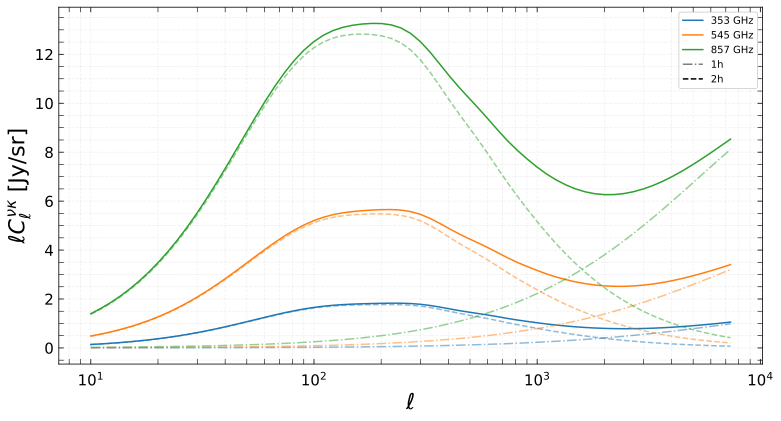

In [20]:
#Get Data
ells = np.asarray(Dl_lens_cib['545']['ell'])
factor = cl_to_dl(ells)

#Font Settings
label_size = 15
title_size = 22
legend_size = 13

#Colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
a = 0.5

for i, nu in enumerate(nu_list):
    #Extract Data
    nu_name = str(nu)
    cl_1h = np.asarray(Dl_lens_cib[str(nu)]['1h']) / factor
    cl_2h = np.asarray(Dl_lens_cib[str(nu)]['2h']) / factor
    cl_tot = cl_1h + cl_2h

    #Plot
    plt.plot(ells, ells * cl_tot, label= nu_name + ' GHz', color=colors[i])
    plt.plot(ells, ells * cl_1h, '-.', alpha= a, color=colors[i])
    plt.plot(ells, ells * cl_2h, '--', alpha= a, color=colors[i])

    #Figure Size
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_figheight(6)
    fig.set_figwidth(11)
    

    #Legend
    line_1h = mpl.lines.Line2D([0], [0], label='1h', color='black', linestyle='-.', alpha= a)
    line_2h = mpl.lines.Line2D([0], [0], label='2h', color='black', linestyle='--')
    h, l = ax.get_legend_handles_labels()
    h.extend([line_1h, line_2h])
    plt.legend(handles= h)

    #Labels
    plt.xlabel(r'$\ell$', fontsize= title_size)
    plt.ylabel(r'$\ell C^{\nu\kappa}_{\ell}$ [Jy/sr]', size= title_size)
    plt.xscale('log')
    # plt.yscale('log')
    
    #Ticks
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax.tick_params(axis = 'x',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=10)
    ax.tick_params(axis = 'y',which='both',length=5,direction='in', top=True, right=True, labelsize=label_size, pad=5)
    ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
    
plt.tight_layout()
plt.savefig('figures/cls_CIB_CMB_lensing.pdf')